# Yelp API - Lab


## Introduction 

We've seen how the Yelp API works and how to create basic visualizations using Folium. It's time to put those skills to work in order to create a working map! Taking things a step further, you'll also independently explore how to perform pagination in order to retrieve a full results set from the Yelp API!

## Objectives

You will be able to: 

* Using pagination and multiple functions, gather large amounts of data from an API, parse the data and make sense of it with meaningful analysis
* Create maps using Folium

## Problem Introduction

You've now worked with some API calls, but we have yet to see how to retrieve a more complete dataset in a programmatic manner. Returning to the Yelp API, the [documentation](https://www.yelp.com/developers/documentation/v3/business_search) also provides us details regarding the API limits. These often include details about the number of requests a user is allowed to make within a specified time limit and the maximum number of results to be returned. In this case, we are told that any request has a maximum of 50 results per request and defaults to 20. Furthermore, any search will be limited to a total of 1000 results. To retrieve all 1000 of these results, we would have to page through the results piece by piece, retrieving 50 at a time. Processes such as these are often referred to as pagination.

In this lab, you will define a search and then paginate over the results to retrieve all of the results. You'll then parse these responses as a DataFrame (for further exploration) and create a map using Folium to visualize the results geographically.

## Part I - Make the Initial Request

Start by making an initial request to the Yelp API. Your search must include at least 2 parameters: **term** and **location**. For example, you might search for pizza restaurants in NYC. The term and location is up to you but make the request below.

In [3]:
# Your code here
import requests
import json

def get_keys(path):
    with open(path) as f:
        return json.load(f)

keys = get_keys("/Users/berke/.secret/yelp_api.json")
api_key = keys['api_key']

url = 'https://api.yelp.com/v3/businesses/search'
url_params = {'term': 'sushi', 'location': 'Raleigh'}
headers = {'Authorization': f'Bearer {api_key}'}

response = requests.get(url, headers=headers, params=url_params)
print(response.status_code)

200


## Pagination

Now that you have an initial response, you can examine the contents of the JSON container. For example, you might start with ```response.json().keys()```. Here, you'll see a key for `'total'`, which tells you the full number of matching results given your query parameters. Write a loop (or ideally a function) which then makes successive API calls using the offset parameter to retrieve all of the results (or 5000 for a particularly large result set) for the original query. As you do this, be mindful of how you store the data. Your final goal will be to reformat the data concerning the businesses themselves into a pandas DataFrame from the json objects.

**Note: be mindful of the API rate limits. You can only make 5000 requests per day and are also can make requests too fast. Start prototyping small before running a loop that could be faulty. You can also use time.sleep(n) to add delays. For more details see https://www.yelp.com/developers/documentation/v3/rate_limiting.**

In [11]:
# Your code here; use a function or loop to retrieve all the results from your original request
print(response.json().keys())
print(type(response.json()['businesses']))
print(type(response.json()['total']))
print(response.json()['region'].keys())

dict_keys(['businesses', 'total', 'region'])
<class 'list'>
<class 'int'>
dict_keys(['center'])


In [13]:
response.json()['total']

308

In [32]:
def get_results(term, location, url= 'https://api.yelp.com/v3/businesses/search', cred="/Users/berke/.secret/yelp_api.json", offset=0):
    
    #setting up the credentials for authorization
    keys = get_keys(cred)
    api_key = keys['api_key']
    headers = {'Authorization': f'Bearer {api_key}'}
    #setting up the parameters
    url_params = {'term': term, 'location': location, 'offset': offset}
    
    response = requests.get(url, headers=headers, params=url_params)
    return response.json()

In [35]:
offset=0
response = get_results(term='sushi', location='Raleigh')
total_results = response['total']
responses = response['businesses']

while offset < total_results:
    response = get_results(term = 'sushi', location = 'Raleigh', offset=offset)
    responses.extend(response['businesses'])
    offset += 20
responses[:5]

[{'id': 'lc_XHCvUoddQoTcd6YR1eQ',
  'alias': 'ajisai-japanese-fusion-raleigh',
  'name': 'Ajisai Japanese Fusion',
  'image_url': 'https://s3-media1.fl.yelpcdn.com/bphoto/aMu6Eo-LzJIKRROU8Zsmxg/o.jpg',
  'is_closed': False,
  'url': 'https://www.yelp.com/biz/ajisai-japanese-fusion-raleigh?adjust_creative=KPbihqsIS72Bx1mExRvCEw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=KPbihqsIS72Bx1mExRvCEw',
  'review_count': 517,
  'categories': [{'alias': 'japanese', 'title': 'Japanese'},
   {'alias': 'sushi', 'title': 'Sushi Bars'}],
  'rating': 4.5,
  'coordinates': {'latitude': 35.79012, 'longitude': -78.659671},
  'transactions': ['delivery', 'pickup'],
  'price': '$$',
  'location': {'address1': '427 Woodburn Rd',
   'address2': None,
   'address3': '',
   'city': 'Raleigh',
   'zip_code': '27605',
   'country': 'US',
   'state': 'NC',
   'display_address': ['427 Woodburn Rd', 'Raleigh, NC 27605']},
  'phone': '+19198319907',
  'display_phone': '(919) 831-9907',
  'd

In [42]:
def get_all_results(term, location, offset=0):
    response = get_results(term=term, location=location, offset=offset)
    total_results = response['total']
    responses = response['businesses']
    
    while offset < total_results:
        response = get_results(term=term, location=location, offset=offset)
        responses.extend(response['businesses'])
        offset += 20
    return responses

In [43]:
get_all_results(term='sushi', location='Raleigh')


[{'id': 'lc_XHCvUoddQoTcd6YR1eQ',
  'alias': 'ajisai-japanese-fusion-raleigh',
  'name': 'Ajisai Japanese Fusion',
  'image_url': 'https://s3-media1.fl.yelpcdn.com/bphoto/aMu6Eo-LzJIKRROU8Zsmxg/o.jpg',
  'is_closed': False,
  'url': 'https://www.yelp.com/biz/ajisai-japanese-fusion-raleigh?adjust_creative=KPbihqsIS72Bx1mExRvCEw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=KPbihqsIS72Bx1mExRvCEw',
  'review_count': 517,
  'categories': [{'alias': 'japanese', 'title': 'Japanese'},
   {'alias': 'sushi', 'title': 'Sushi Bars'}],
  'rating': 4.5,
  'coordinates': {'latitude': 35.79012, 'longitude': -78.659671},
  'transactions': ['pickup', 'delivery'],
  'price': '$$',
  'location': {'address1': '427 Woodburn Rd',
   'address2': None,
   'address3': '',
   'city': 'Raleigh',
   'zip_code': '27605',
   'country': 'US',
   'state': 'NC',
   'display_address': ['427 Woodburn Rd', 'Raleigh, NC 27605']},
  'phone': '+19198319907',
  'display_phone': '(919) 831-9907',
  'd

## Exploratory Analysis

Take the restaurants from the previous question and do an initial exploratory analysis. At minimum, this should include looking at the distribution of features such as price, rating and number of reviews as well as the relations between these dimensions.

In [88]:
responses[0].keys()

dict_keys(['id', 'alias', 'name', 'image_url', 'is_closed', 'url', 'review_count', 'categories', 'rating', 'coordinates', 'transactions', 'price', 'location', 'phone', 'display_phone', 'distance'])

In [45]:
# Your code here
import pandas as pd
df = pd.DataFrame(responses)
df.head()

id                              alias  \
0  lc_XHCvUoddQoTcd6YR1eQ     ajisai-japanese-fusion-raleigh   
1  emIw8zjs7FUKz3Vxd8RkZw                  sushi-mon-raleigh   
2  z03yUG3Os6qn5WTbuh-8jQ     kai-sushi-and-sake-bar-raleigh   
3  WtE8V9Tg8crGqErRtMePWQ        city-market-sushi-raleigh-2   
4  S_iZrmUxlTOE4RyC3IK7jQ  sono-sushi-restaurant-bar-raleigh   

                        name  \
0     Ajisai Japanese Fusion   
1                  Sushi Mon   
2     Kai Sushi and Sake Bar   
3          City Market Sushi   
4  Sono Sushi Restaurant Bar   

                                           image_url  is_closed  \
0  https://s3-media1.fl.yelpcdn.com/bphoto/aMu6Eo...      False   
1  https://s3-media2.fl.yelpcdn.com/bphoto/6OovUX...      False   
2  https://s3-media3.fl.yelpcdn.com/bphoto/gng9yZ...      False   
3  https://s3-media1.fl.yelpcdn.com/bphoto/vsS0bM...      False   
4  https://s3-media3.fl.yelpcdn.com/bphoto/QokerE...      False   

                                                 url  review_count  \
0  https://www.yelp.com/biz/ajisai-japanese-fusio...           517   
1  https://www.yelp.com/biz/sushi-mon-raleigh?adj...           177   
2  https://www.yelp.com/biz/kai-sushi-and-sake-ba...           384   
3  https://www.yelp.com/biz/city-market-sushi-ral...           250   
4  https://www.yelp.com/biz/sono-sushi-restaurant...           513   

                                          categories  rating  \
0  [{'alias': 'japanese', 'title': 'Japanese'}, {...     4.5   
1  [{'alias': 'japanese', 'title': 'Japanese'}, {...     4.5   
2  [{'alias': 'japanese', 'title': 'Japanese'}, {...     4.5   
3        [{'alias': 'sushi', 'title': 'Sushi Bars'}]     4.5   
4  [{'alias': 'japanese', 'title': 'Japanese'}, {...     4.5   

                                         coordinates  \
0    {'latitude': 35.79012, 'longitude': -78.659671}   
1     {'latitude': 35.83067, 'longitude': -78.66617}   
2   {'latitude': 35.886173, 'longitude': -78.660438}   
3  {'latitude': 35.7764897, 'longitude': -78.6355...   
4  {'latitude': 35.7753358636598, 'longitude': -7...   

                                 transactions price  \
0                          [delivery, pickup]    $$   
1  [pickup, restaurant_reservation, delivery]    $$   
2                          [delivery, pickup]    $$   
3                                  [delivery]    $$   
4                          [delivery, pickup]    $$   

                                            location         phone  \
0  {'address1': '427 Woodburn Rd', 'address2': No...  +19198319907   
1  {'address1': '3700 Glenwood Ave', 'address2': ...  +19198031000   
2  {'address1': '7713 Lead Mine Rd', 'address2': ...  +19198704923   
3  {'address1': '315 Blake St', 'address2': '', '...  +19193221987   
4  {'address1': '319 Fayetteville St', 'address2'...  +19195215328   

    display_phone     distance  
0  (919) 831-9907  3758.783068  
1  (919) 803-1000  1605.178486  
2  (919) 870-4923  7085.792979  
3  (919) 322-1987  5407.371014  
4  (919) 521-5328  5422.878298

In [61]:
df['price'].map(lambda x: len(x))

TypeError: object of type 'float' has no len()

In [64]:
conversion = {'$': 1, '$$': 2, '$$$': 3}
df['numeric_price'] = df['price'].map(conversion)
df.head()

id                              alias  \
0  lc_XHCvUoddQoTcd6YR1eQ     ajisai-japanese-fusion-raleigh   
1  emIw8zjs7FUKz3Vxd8RkZw                  sushi-mon-raleigh   
2  z03yUG3Os6qn5WTbuh-8jQ     kai-sushi-and-sake-bar-raleigh   
3  WtE8V9Tg8crGqErRtMePWQ        city-market-sushi-raleigh-2   
4  S_iZrmUxlTOE4RyC3IK7jQ  sono-sushi-restaurant-bar-raleigh   

                        name  \
0     Ajisai Japanese Fusion   
1                  Sushi Mon   
2     Kai Sushi and Sake Bar   
3          City Market Sushi   
4  Sono Sushi Restaurant Bar   

                                           image_url  is_closed  \
0  https://s3-media1.fl.yelpcdn.com/bphoto/aMu6Eo...      False   
1  https://s3-media2.fl.yelpcdn.com/bphoto/6OovUX...      False   
2  https://s3-media3.fl.yelpcdn.com/bphoto/gng9yZ...      False   
3  https://s3-media1.fl.yelpcdn.com/bphoto/vsS0bM...      False   
4  https://s3-media3.fl.yelpcdn.com/bphoto/QokerE...      False   

                                                 url  review_count  \
0  https://www.yelp.com/biz/ajisai-japanese-fusio...           517   
1  https://www.yelp.com/biz/sushi-mon-raleigh?adj...           177   
2  https://www.yelp.com/biz/kai-sushi-and-sake-ba...           384   
3  https://www.yelp.com/biz/city-market-sushi-ral...           250   
4  https://www.yelp.com/biz/sono-sushi-restaurant...           513   

                                          categories  rating  \
0  [{'alias': 'japanese', 'title': 'Japanese'}, {...     4.5   
1  [{'alias': 'japanese', 'title': 'Japanese'}, {...     4.5   
2  [{'alias': 'japanese', 'title': 'Japanese'}, {...     4.5   
3        [{'alias': 'sushi', 'title': 'Sushi Bars'}]     4.5   
4  [{'alias': 'japanese', 'title': 'Japanese'}, {...     4.5   

                                         coordinates  \
0    {'latitude': 35.79012, 'longitude': -78.659671}   
1     {'latitude': 35.83067, 'longitude': -78.66617}   
2   {'latitude': 35.886173, 'longitude': -78.660438}   
3  {'latitude': 35.7764897, 'longitude': -78.6355...   
4  {'latitude': 35.7753358636598, 'longitude': -7...   

                                 transactions price  \
0                          [delivery, pickup]    $$   
1  [pickup, restaurant_reservation, delivery]    $$   
2                          [delivery, pickup]    $$   
3                                  [delivery]    $$   
4                          [delivery, pickup]    $$   

                                            location         phone  \
0  {'address1': '427 Woodburn Rd', 'address2': No...  +19198319907   
1  {'address1': '3700 Glenwood Ave', 'address2': ...  +19198031000   
2  {'address1': '7713 Lead Mine Rd', 'address2': ...  +19198704923   
3  {'address1': '315 Blake St', 'address2': '', '...  +19193221987   
4  {'address1': '319 Fayetteville St', 'address2'...  +19195215328   

    display_phone     distance  numeric_price  
0  (919) 831-9907  3758.783068            2.0  
1  (919) 803-1000  1605.178486            2.0  
2  (919) 870-4923  7085.792979            2.0  
3  (919) 322-1987  5407.371014            2.0  
4  (919) 521-5328  5422.878298            2.0

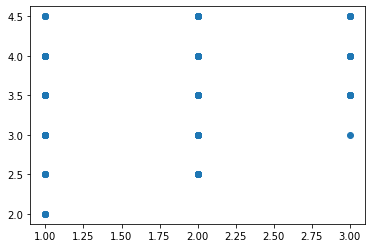

In [76]:
df.corr()
#very low correlation between price & rating which means higher price does not equal to better sushi.
#also very low correlation between review counts & ratings and price & review counts.

import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots()
ax.scatter(df['numeric_price'], df['rating']);

## Mapping

Look at the initial Yelp example and try and make a map using Folium of the restaurants you retrieved. Be sure to also add popups to the markers giving some basic information such as name, rating and price.

In [80]:
# Your code here
import folium

lat = 35.7796
long = -78.6382

base_map = folium.Map([lat,long], zoom_start=13)
base_map

In [97]:
# for business in responses:
#     print(business['price']) 
    
df['price'].fillna(value=0)

for cell in df['price']:
    print(cell)

$$
$$
$$
$$
$$
$$
$$
nan
$$
$$
$$
$$
$$
$$
$$
$$
$$
$$
$$
nan
$$
$$
$$
$$
$$
$$
$$
nan
$$
$$
$$
$$
$$
$$
$$
$$
$$
$$
$$
nan
nan
$$
$$
$$
$$
$$
$$
$$
$
$$
$$
$$
$$
nan
$$
$$
$$
$$$
$$
$$
$
nan
$$
nan
$$
$$
$
$$
$$
$
$$
nan
$
$$
$$
$$
$$
nan
nan
nan
$$
$
$$$$
$$
$$
$$
$$
nan
$$
$$
nan
$$
$
$
$
$
nan
$$
$$
$$
$$
nan
$$
$$
$$
$$
$$
$$
nan
$
$$
nan
$$
$
$$
$$
$$
$
$$
$$
$
$$
$$
$
$
$
$$
$$
$$
$$
$$
$$
$$
$$$
$$
nan
$$
$$
$
$$
$$
$$
nan
$
$$
$
$$
$$
$$
$
$
$
$$
$
$$
nan
$$
$$
$$
nan
$$
$$
$
$
$$
$
$$
nan
$$
$$
$$
$
$$
$$
$$
$$
nan
$
$$$
$
$$
$$
$$
$$
nan
$$$
$$
nan
$$
$$
$
$
$$
$$
$$
$$
$$
nan
nan
$$
$
$$
$
$$
$$
$$
$$
$
$$
$$
$
nan
$$
$$
$$
$$$
$$
$$
$$
$
$$
$$$
$$
$
nan
$$
$$
$$
nan
$$
$$
$$
$$
$
$$
$
$
$$
$
$$$
$$
$$
$$
$$
$$
$$
$$
$
$$
$
$$
$$
$$
$
$$
$
$$
$$
$$
$$$$
$$$
$$
$$
$
$$$
$$
$$
$$
$$$
$$
$$
$$$
$$
$
$$
$$
$
$$
$
$
$$
$$
$$
$$
$$
$$
$$
$$
$
$$
$$
$$
$$$
$$
$$
$$
$
$$
$$
$$
$
nan
$$
$$
$$
$$
$
$$$
$$
$$
$
$$$
$
$$$
$$
$
$$
$$
$$
nan
$$$
$$$
$$
$$
$$$
$$
$$
$$


In [100]:
lat = [business['coordinates']['latitude'] for business in responses]
lon = [business['coordinates']['longitude'] for business in responses]
name = [business['name'] for business in responses]
rating = [business['rating'] for business in responses]
price = [cell for cell in df['price']]


points = list(zip(lat, lon))
index = 0
for p in points:
    lati = p[0]
    long = p[1]
    
    popup_text = f"Name: {name[index]}, Rating: {rating[index]}, Price: {price[index]}, Latitude: {lati}, Longitude: {long}"
    popup = folium.Popup(popup_text, parse_html=True)
    
    marker = folium.Marker(location=[lati, long], popup=popup)
    marker.add_to(base_map)
    index +=1
base_map

## Summary

Nice work! In this lab, you've made multiple API calls to Yelp in order to paginate through a results set, performing some basic exploratory analysis and then creating a nice interactive map to display the results using Folium! Well done!